# Visualisation of grid generation results

In this notebook the characteristics of a pylovo grid are explained.
For an example grid the elements (consumers, trafos, cables) are added step by step.

In [1]:
from syngrid.GridGenerator import GridGenerator
import geopandas as gpd
import contextily as cx
from matplotlib import pyplot as plt
from shapely import linestrings
import sys
import os
from pandapower.plotting.plotly import simple_plotly
import plotly.express as px
import warnings
warnings.filterwarnings('ignore') # Im Zwecke der Sauberkeit des notebooks werden Warnungen unterdrückt
sys.path.append(os.path.abspath('..'))
access_token = 'pk.eyJ1IjoibXVza2F0bnVzcyIsImEiOiJjbGdxYnVyY28wN3lhM2VvMnBtYWwxZGl6In0.y5gIcGJSpwb0X4wgQQVolA'
px.set_mapbox_access_token(access_token)

Connect to database to retrieve information for given PLZ:

In [2]:
plz = "80639"
gg = GridGenerator(plz=plz)
pg = gg.pgr

PgReaderWriter is constructed. 
Version: 14.1 (already exists)
Parameter tables are inserted


## Postcode area
as a preliminary step we can look at the PLZ area we selected

[]

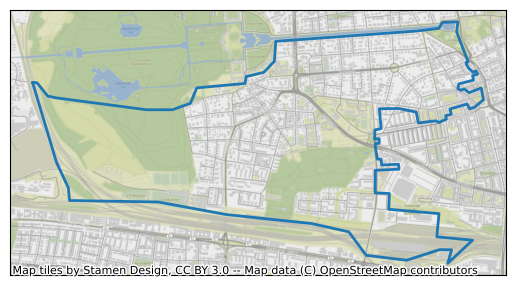

In [3]:
postcode_gdf = pg.getGeoDataFrame(table="postcode_result", id=plz)
fig, ax = plt.subplots()
ax = postcode_gdf.boundary.plot(ax=ax, figsize=(10, 10), linewidth=2,)
cx.add_basemap(ax, crs=postcode_gdf.crs.to_string())#, zoom= 17)
ax.set_xticks([])
ax.set_yticks([])

## Buildings
The buildings are added inserted into the PLZ area.

In [4]:
buildings_gdf = pg.getGeoDataFrame(table="buildings_result",in_loadarea_cluster=int(plz))

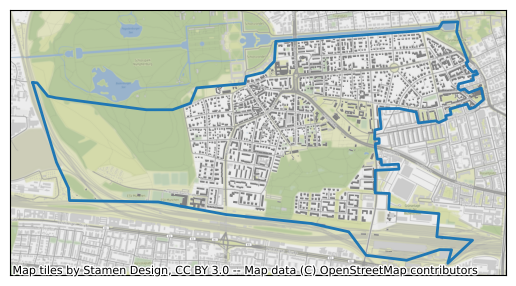

<Figure size 640x480 with 0 Axes>

In [5]:
ax = buildings_gdf.plot(ax=ax, legend=True, color="grey")
fig

## Building clusters
A PLZ area contains multiple LV grids. Nearby buildings are clustered to form one grid.

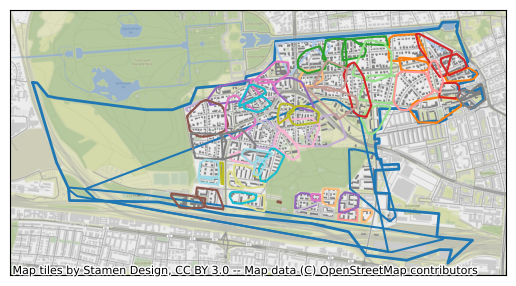

<Figure size 640x480 with 0 Axes>

In [6]:
buildings_gdf.dissolve(by="in_building_cluster").convex_hull.boundary.plot(ax=ax, cmap="tab20")
fig

This seems messy.
Try to color the buildings instead

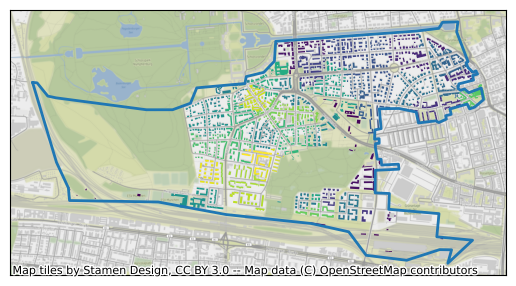

In [7]:
fig, ax = plt.subplots()
ax = postcode_gdf.boundary.plot(ax=ax, figsize=(10, 10), linewidth=2,)
cx.add_basemap(ax, crs=postcode_gdf.crs.to_string())
ax.set_xticks([])
ax.set_yticks([])
ax = buildings_gdf.plot(ax = ax, column="in_building_cluster")#, cmap="tab20")

Let's number the clusters

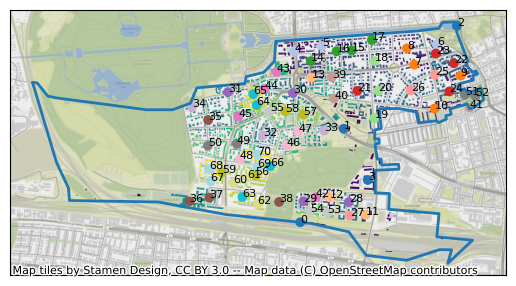

<Figure size 640x480 with 0 Axes>

In [8]:
buildings_gdf.dissolve(by="in_building_cluster").centroid.plot(ax=ax, cmap="tab20")
for  index, row in buildings_gdf.dissolve(by="in_building_cluster").centroid.items():
        x = row.x
        y = row.y
        ax.text(x, y, index, fontsize=8)
fig

## One LV grid
We can now focus on one cluster.
The cluster list contains all networks ordered by bcid (buildings cluster id) and kcid (kmeans cluster id)

In [9]:
cluster_list = pg.getListFromPlz(plz)
cluster_list

[(1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (1, 32),
 (1, 33),
 (1, 34),
 (1, 35),
 (1, 36),
 (1, 37),
 (1, 38),
 (1, 39),
 (1, 40),
 (1, 41),
 (1, 42),
 (1, 43),
 (1, 44),
 (1, 45),
 (1, 46),
 (1, 47),
 (1, 48),
 (1, 49),
 (1, 50),
 (1, 51),
 (1, 52),
 (1, 53),
 (1, 54),
 (1, 55),
 (1, 56),
 (1, 57),
 (1, 58),
 (1, 59),
 (1, 60),
 (1, 61),
 (1, 62),
 (1, 63),
 (1, 64),
 (1, 65),
 (1, 66),
 (1, 67),
 (1, 68),
 (1, 69),
 (1, 70),
 (2, 0),
 (2, 1),
 (3, 0),
 (4, 0),
 (4, 1),
 (5, 0),
 (5, 1)]

From cluster list we choose a tuple (kcid, bcid)

In [10]:
kcid = 1
bcid = 1

### Buildings
First, let's look at the buildings that get served by our grid

The consumers are situated in the buildings
The number of buildings in the net are:

In [11]:
buildings_8_gdf = buildings_gdf[buildings_gdf.in_building_cluster == bcid]
buildings_8_gdf = buildings_8_gdf[buildings_8_gdf.k_mean_cluster == kcid]
len(buildings_8_gdf)

9

The builings are colored according to their estimated peak load. The peak loads depends on the type of building (residential, commercial, public), square footage , numer of floors and number of households.

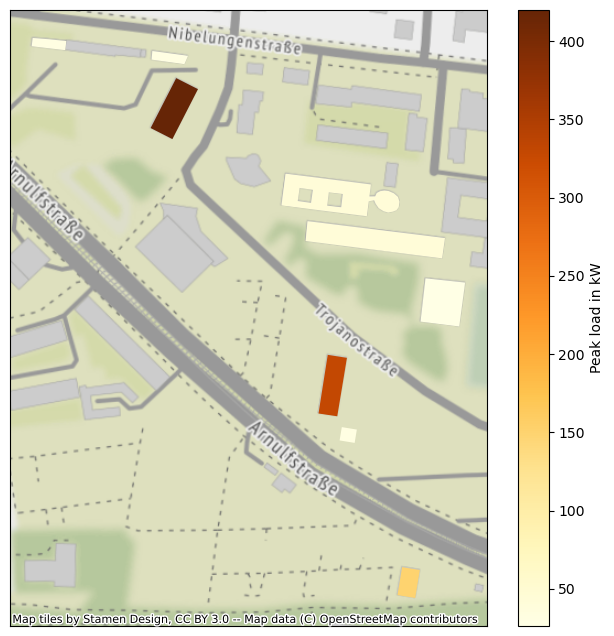

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([])
ax.set_yticks([])
ax = buildings_8_gdf.plot(ax = ax, column="peak_load_in_kw", cmap="YlOrBr",
                          legend=True,legend_kwds={'label': "Peak load in kW"})
cx.add_basemap(ax, crs=buildings_8_gdf.crs.to_string(), zoom=17)

### Transformer
Each grid needs a transformer that connects the LV grid to the MV distribution system. This transformer is either obtained from OSM or positioned ideally by pylovo.

In [13]:
trafo_gdf = pg.getGeoDataFrame(table="transformer_positions", loadarea_cluster=int(plz), building_cluster=bcid)

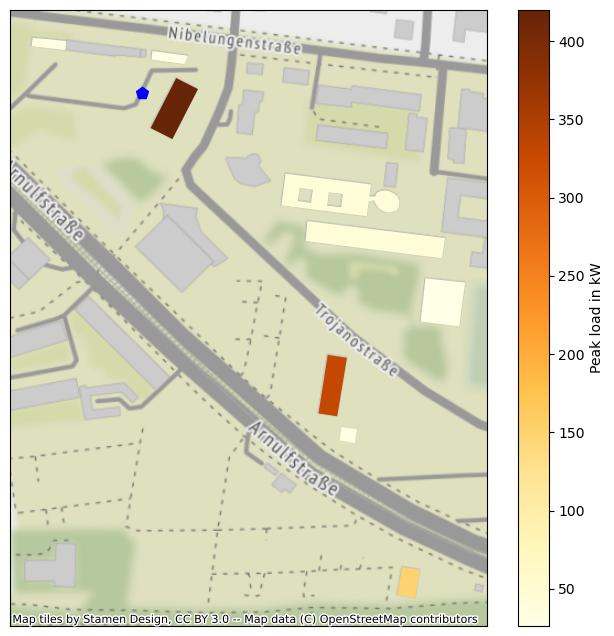

In [14]:
ax.scatter(trafo_gdf.loc[0].geom.x, trafo_gdf.loc[0].geom.y, marker=(5,0), s=80, color="blue", label="Transformer")
fig

## Streets
Cables are laid along the streets. From the street houses are connected.

<Axes: >

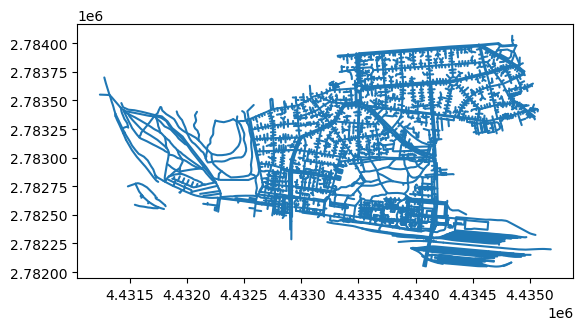

In [15]:
ways_gdf = pg.getGeoDataFrame(table="ways_result", plz=f"'{plz}'")
ways_gdf.plot()

We can filter ways around the predefined cluster

In [16]:
# The area around cluster 
cluster_region = buildings_8_gdf.dissolve().convex_hull.buffer(50)
cluster_region_gdf = gpd.GeoDataFrame(geometry=cluster_region)

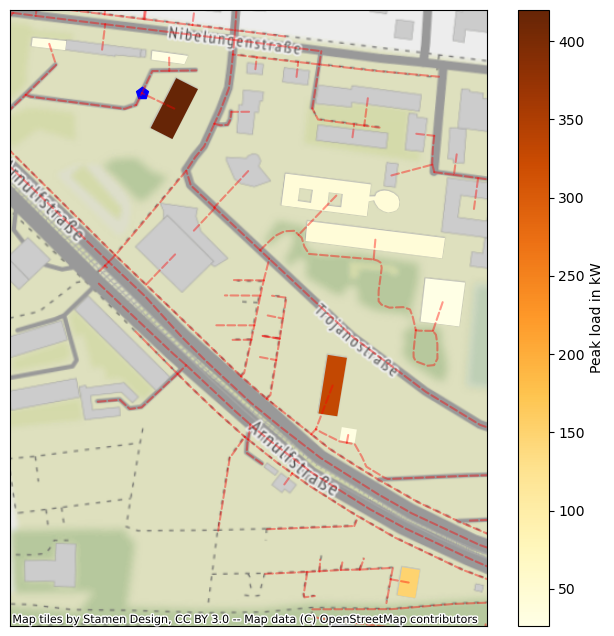

<Figure size 640x480 with 0 Axes>

In [17]:
ways_8_gdf = gpd.tools.sjoin(ways_gdf, cluster_region_gdf, how='inner')
ax = ways_8_gdf.plot(ax=ax, edgecolor="red", linestyle="--", alpha=0.4, label="Streets")
fig

## Generated Grid
Pylovo joins all the the elements shown above into a pandapower network.

In [18]:
net = pg.read_net(plz=plz, kcid=kcid, bcid=bcid)
net

This pandapower network includes the following parameter tables:
   - bus (20 element)
   - load (36 element)
   - ext_grid (1 elements)
   - line (18 element)
   - trafo (1 elements)
   - line_geodata (18 element)
   - bus_geodata (20 element)

This network only contains cable routes along the streets that are needed to supply all consumers (buildings).

<Axes: >

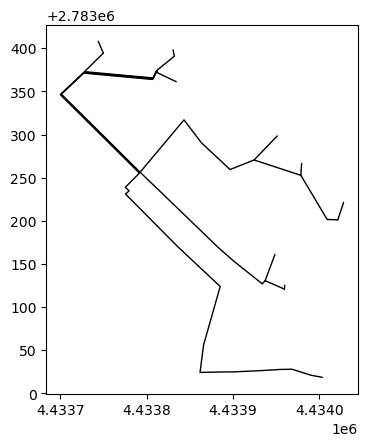

In [19]:
net.line_gdf = gpd.GeoDataFrame(net.line.copy(), geometry=net.line_geodata.coords.map(linestrings), crs="EPSG:4326").to_crs(buildings_8_gdf.crs.to_string())
net.line_gdf.plot(edgecolor="black", linewidth=1)

Now all the elements can be put together: transformer, cables and consumers.

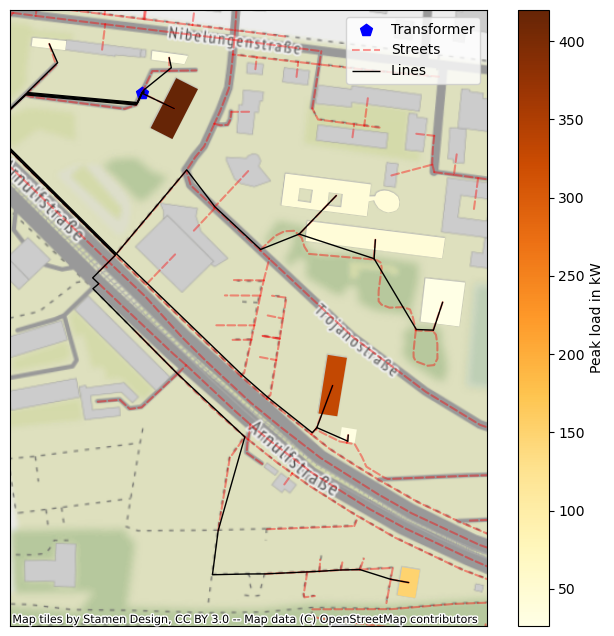

<Figure size 640x480 with 0 Axes>

In [20]:
ax = net.line_gdf.plot(ax=ax, edgecolor="black", linewidth=1, label="Lines")
ax.legend()
fig

Note that some buildings portrayed on the baselayer map belong to a different grid or may have a peak load above 100 kW which means that they are directly connected to the MV grid.

For more details about the network graph check out the notebook 'LV network graph representation'.

In [21]:
plz = "81541"
cluster_list =[]
for i in pg.getListFromPlz(int(plz)): cluster_list.append(i[1])
cluster_list

[]

PgReaderWriter is constructed. 
Version: 14.1 (already exists)
Parameter tables are inserted
PgReaderWriter closed.
PgReaderWriter closed.


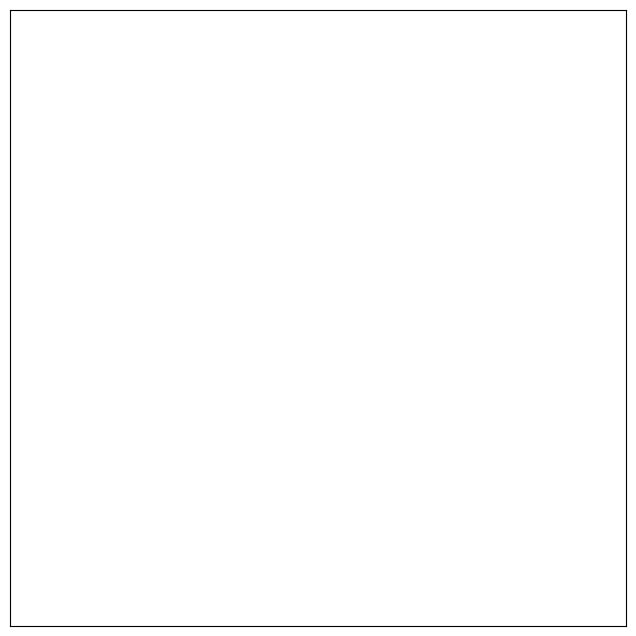

interactive(children=(Dropdown(description='cluster', options=(), value=None), Output()), _dom_classes=('widge…

In [22]:
from ipywidgets import interact, widgets

plz = "80687"
gg = GridGenerator(plz=plz)
pg = gg.pgr

#cluster_list =[]
#for i in pg.getListFromPlz(int(plz)): cluster_list.append(i[1])
@interact(cluster = cluster_list)
# interact(f, x=widgets.IntSlider(min=1, max=50, step=1, value=1))

def f(cluster):
    # prepare figure
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    # buildings
    buildings_gdf = pg.getGeoDataFrame(table="buildings_result",in_loadarea_cluster=int(plz))
    buildings_8_gdf = buildings_gdf[buildings_gdf.in_building_cluster == cluster]
    ax = buildings_8_gdf.plot(ax = ax, column="peak_load_in_kw", cmap="YlOrBr",
                              legend=True,legend_kwds={'label': "Peak load in kW"})
    cx.add_basemap(ax, crs=buildings_8_gdf.crs.to_string(), zoom=17)

    # ways for plz
    ways_gdf = pg.getGeoDataFrame(table="ways_result", plz=f"'{plz}'")
    cluster_region = buildings_8_gdf.dissolve().convex_hull.buffer(50) # The area around cluster
    cluster_region_gdf = gpd.GeoDataFrame(geometry=cluster_region)
    ways_8_gdf = gpd.tools.sjoin(ways_gdf, cluster_region_gdf, how='inner')
    ax = ways_8_gdf.plot(ax=ax, edgecolor="red", linestyle="--", alpha=0.4, label="Streets")

    # trafo
    trafo_gdf = pg.getGeoDataFrame(table="transformer_positions", loadarea_cluster=int(plz), building_cluster=cluster)
    ax.scatter(trafo_gdf.loc[0].geom.x, trafo_gdf.loc[0].geom.y, marker=(5,0), s=80, color="blue", label="Transformer")

    # load derived network
    net = pg.read_net(plz=plz, kcid=1, bcid=cluster)
    net.line_gdf = gpd.GeoDataFrame(net.line.copy(), geometry=net.line_geodata.coords.map(linestrings),
                                    crs="EPSG:4326").to_crs(buildings_8_gdf.crs.to_string())
    ax = net.line_gdf.plot(ax=ax, edgecolor="black", linewidth=1, label="Lines")
    ax.legend()
    return